In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

# Simulating Brownian Motion: sharing realizations at different time resolutions

Alex Gorodetsky, September 2020

In this notebook we look at how to generate simulations of Brownian motion at different time resolutions. This is required for Multilevel Monte Carlo (MLMC) approaches when estimating expectations in the context of differential equations


## The key properties

A Brownian motion is a stochastic process in time, denoted by $W_t$, with the properties 0. _initial condition:_ $W_0 = 0$ a.s

1. _normally distributed:_ $W_t \sim \mathcal{N}(0, t)$
2. _covariance structure:_ $\mathbb{E}\left[W_t  W_s\right] = \min(s, t)$
3. _independent normal increments:_ $W_{t_2} - W_{t_1}$ is distributed according to a normal $\mathcal{N}(0, t_2-t_1)$ and $W_{t_4} - W_{t_3}$ is independent of $W_{t_2} - W_{t_1}$ whenever the time increments don't intersect ($0 \leq t_1 \leq t_2 \leq t_3 \leq t_4$)
4. $W_t$ has continuous paths (as a function of $t$) with probability 1.


## The basic simulation

We will exploit property 3. By seeing that $W(t + \Delta t) - W(t) \sim \mathcal{N}(0, \Delta t)$ So that we can say

\begin{equation}
W^f*{t + \Delta t} = W^f*{t} + \sqrt{\Delta t} \xi, \quad \xi \sim \mathcal{N}(0, 1)
\end{equation}


In [2]:
def brownian_motion_simulate(T, dt):
    """Simulate a single path of brownian motion

    Inputs
    ------
    T: floating point variable, greater than 0, final time 
    dt: time increment of the simulation

    Returns
    -------
    bmotion: single path of a brownian motion simulation
    """
    nsamples = int(np.ceil(T / dt)) + 1
    samples = np.random.randn(nsamples) * np.sqrt(dt)
    samples[0] = 0.0
    bmotion = np.cumsum(samples)
    return bmotion

## Generating shared realizations


Our goal is to build two sets of Brownian motion simulations that share an "underlying realization."

1. $W_t^{f}$: this BM is going to be simulated with time step $\Delta t$
2. $W_t^{c}$: this BM is going to be simualted with time step $M \Delta t$; $M$ is an integer

\begin{equation}
W*{t+M\Delta t}^{c}= W*{t}^c + \sqrt{M \Delta t} \xi, \quad \xi \sim \mathcal{N}(0, 1)
\end{equation}

From the fine-scale simulation

\begin{equation}
W*{t+ M\Delta t}^f - W*{t}^f \sim \mathcal{N}(0, M\Delta t)
\end{equation}

Since these two share the statistical properties required at every $M \Delta t$ times, we can use the fine-scale path to extract the coarse-scale path by looking at every $M$th sample


In [3]:
def brownian_motion_fine_to_coarse(T, dt, brownian_fine, M):
    """Extract a sample of a coarse brownian motion simulation from a fine brownian motion simulation"""

    nsamples = int(np.ceil(T/dt)) + 1
    brownian_coarse = np.zeros((nsamples))
    brownian_coarse[0] = brownian_fine[0]
    for ii in range(1, nsamples):
        delta = brownian_fine[ii * M] - brownian_fine[(ii-1)*M]
        brownian_coarse[ii] = brownian_coarse[ii-1] + delta
    return brownian_coarse

Lets visualize what shared samples mean


In [4]:
M = 4
DT = 0.025  # fine scale time step
DTM = DT * M  # coarse scale time step
TFINAL = 1.0  # final time
TSPAN_COARSE = np.arange(0, TFINAL + DTM, DTM)
TSPAN_FINE = np.arange(0, TFINAL+DT, DT)
brownian_fine = brownian_motion_simulate(TFINAL, DT)
brownian_coarse = brownian_motion_fine_to_coarse(TFINAL, DTM, brownian_fine, M)

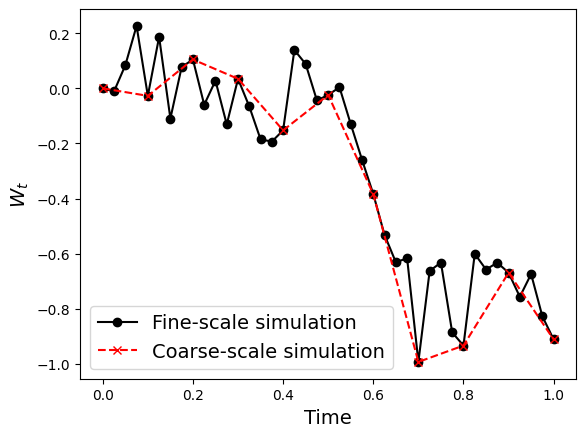

In [5]:
plt.figure()
plt.plot(TSPAN_FINE, brownian_fine, '-ko', label='Fine-scale simulation')
plt.plot(TSPAN_COARSE, brownian_coarse, '--rx',
         label='Coarse-scale simulation')
plt.xlabel('Time', fontsize=14)
plt.ylabel(r'$W_t$', fontsize=14)
plt.legend(fontsize=14)
plt.show()